In [359]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import textwrap

def drawGraph(data2Draw,current,trues,pos):
    
    if drawActive == False:
        return ""
    
    text = str("Now we delete:"+textwrap.fill(str(current), 40)+"\n\n\n\nTrues: "+textwrap.fill(str(trues), 40))
    #print (text)
    #return
    width = 10
    height = 15
    plt.figure(figsize=(width, height))
    dx = nx.DiGraph()
    dx = nx.nx.complete_multipartite_graph(1,2,3,4)
    dx.add_nodes_from(data2Draw['members'])
    dx.add_edges_from(data2Draw['edges'])
    if pos == 0:
        pos = nx.random_layout(dx,2,4)
    nx.draw_networkx_labels(dx, pos, data2Draw['labels'], font_size=16)
    nx.draw_networkx_nodes(dx, pos, nodelist=data2Draw['members'], node_color='r',node_size=700)
    nx.draw_networkx_nodes(
        dx, pos, nodelist=data2Draw['name'], node_color='y', node_shape='s', node_size=1300, linewidths=10)
    nx.draw_networkx_edges(
        dx, pos, edgelist=data2Draw['edges'], edge_color='b', arrows=True)
    
    

    red_patch = mpatches.Patch(color='red', label='Members')
    yellow_patch = mpatches.Patch(color='y', label='Lamdas')
    
    
    plt.legend(handles=[red_patch,yellow_patch], loc=1)
    plt.annotate(text,xy=(1.05,0.5),xycoords='axes fraction', fontsize=14)
    plt.show()
    return pos


In [416]:
def mergeDict(dictA, dictB):
    for m in dictB.keys():
        if m not in dictA.keys():
            dictA[m] = dictB[m]
        dictA[m] = (dictA[m])
    return dictA

def mergeData(data1, data2):
    allData = {}
    allData['labels'] = mergeDict(data1['labels'], data2['labels'])
    allData['edges'] = data1['edges'] | data2['edges']
    allData['members'] = data1['members'] | data2['members']
    allData['name'] = list(set().union(data1['name'],[data2['name']]))
    return allData

def getData(sentence):
    leftMembers = sentence['leftMembers']
    name = sentence['name']
    rightMembers = sentence['rightMembers']
    labels = {}
    edges = []
    for m in leftMembers:
        labels[m] = m
        edges.append((m, name))
    for m in rightMembers:
        labels[m] = m
        edges.append((name, m))
    labels[name] = name
#     if len (rightMembers) == 0:
#         leftMembers = []
    return ({'labels':  (labels), 'edges': set(edges),
             'members': set(leftMembers) | set(rightMembers), 'name': name})

In [417]:
import pydot
def drawGraph2(data2Draw):
    graph = pydot.Dot(graph_type='graph')
    pyNodes = {}
    for n in set(data2Draw['members']):
        pyNodes[n] = pydot.Node(n, fillcolor='r')
    for n in set(data2Draw['names']):
        pyNodes[n] = pydot.Node(n, fillcolor="b", shape='box')
    for edge in set(data2Draw['edges']):
        graph.add_edge(pydot.Edge(edge[0], edge[1], label='a', color='r'))
    graph.write_png('ojj.png')

In [418]:
def findIndependetMembers(data,val):
    if val == 0:
        independentMember = {key: 0 for key in set(data['name'])}
    else:
        independentMember = {key: 0 for key in set(data['members'])}

    for k in data['edges']:
        if k[1] in independentMember:
            independentMember[k[1]] += 1
    return [l for l in independentMember.keys() if independentMember[l]==0]


def updateGraph(dataToProcess, trues, pos):
    dataToProcess, lamdasDeleted = removeLambda(dataToProcess, trues, pos)
    dataToProcess, membersDeleted = removeMember(dataToProcess, trues, pos)
    
    return dataToProcess, membersDeleted

def removeLambda(dataToProcess, trues, pos):
    toDelete = findIndependetMembers(dataToProcess,0)
    for e in [l for l in data['edges'] if l[0] in toDelete]:
        dataToProcess['edges'].remove(e)
    for e in toDelete:
        del dataToProcess['labels'][e]
        dataToProcess['name'].remove(e)
        
    drawGraph(dataToProcess,toDelete,trues, pos)        
    return dataToProcess, toDelete

def removeMember(dataToProcess,trues,pos):
    toDelete = findIndependetMembers(dataToProcess,1)
    for e in [l for l in dataToProcess['edges'] if l[0] in toDelete]:
        dataToProcess['edges'].remove(e)
    for e in toDelete:
        del dataToProcess['labels'][e]
        dataToProcess['members'].remove(e)
    drawGraph(dataToProcess,toDelete,trues , pos)    
    return dataToProcess, toDelete

def updateSentencesAndGetTrues(sentences, membersToDelete):
    retValue = []
    for m in membersToDelete:
        for s in sentences:
            if [m] == s['rightMembers']:
                retValue.append(m)
                s['edges'] = []
                continue;
            if m in s['leftMembers']:
                del s
                continue
            if m in s['rightMembers']:
                s['rightMembers'].remove(m)
    return set(retValue), sentences
                
def convertJson2Theory(sentences):
    [print (l['name']+':'+str(l['leftMembers'])+'->'+str(l['rightMembers'])) for l in sentences]          

In [419]:
import random, string

def generateRandomSentences(num,lenght,members,size):
    retValue = []
    for i in range(num):
        val = {}
        lengthR = lengthL = 0
        while lengthL == 0 & lengthR == 0:
            lengthR = int (random_num(lenght))
            lengthL = int (random_num(lenght))
        val = {}
        val['name']= 'L' +str(i)
        val['leftMembers']=[]
        for j in range(lengthL):
            val['leftMembers'].append(randomword(members,size))
        val['rightMembers']=[]
        for j in range(lengthR):
            val['rightMembers'].append(randomword(members,size))
        retValue.append(val)
    return retValue
        
def random_num(length):
    return random.randint(0, length) 


def randomword(members,length):
    return ''.join(random.choice(string.ascii_lowercase[:members]) for i in range(length))

In [427]:
def readFile(filename):
    f = open(filename,'r').read().replace(':[',';').replace(']->[',';').replace(']','').replace("'",'').replace(" ",'')
    allS = f.split('\n')
    listSentences = []
    for i in allS:
        ele = {}
        t = i.split(';')
        ele ['name']=t[0]
        if t[1] == '':
            ele['leftMembers'] = []
        else:
            ele['leftMembers'] = t[1].split(',')
        if t[2] == '':
            ele['rightMembers'] = []
        else:
            ele['rightMembers'] = t[2].split(',')
        listSentences.append(ele)
    return listSentences
def insert_newlines(string, every=64):
    return '\n'.join(string[i:i+every] for i in range(0, len(string), every))

In [432]:
theory = [
    {'leftMembers': [], 'name': ('L1'), 'rightMembers': ['a', 'b']},
    {'leftMembers': ['b'], 'name': ('L2'), 'rightMembers': ['a']},
    {'leftMembers': [], 'name': ('L3'), 'rightMembers': ['a', 'c']},
    {'leftMembers': ['a'], 'name': ('L4'), 'rightMembers': ['d', 'e', 'f']},
    {'leftMembers': ['e'], 'name': ('L5'), 'rightMembers': ['f']},
    {'leftMembers': ['f'], 'name': ('L6'), 'rightMembers': ['e']},
]

In [429]:
theory = generateRandomSentences(7,3,3,1)

In [430]:
def main(theory):
    convertJson2Theory(theory)
    trues = []
    deletedMembers = []
    data = {'name':[],'edges':set(),'members':set(),'labels':{}}
    for oS in theory:
        data = mergeData(data, getData(oS))
    sentences = theory
    pos = ""
    pos = drawGraph(data,deletedMembers,trues, 0)
    #drawGraph2(data)
    lastState = []
    curState = [len(data['name']),len(data['edges']),len(data['members'])]

    while lastState != curState:
        lastState = curState
        data,membersDeleted = updateGraph(data,trues, pos)
        curT, sentences = updateSentencesAndGetTrues(sentences, membersDeleted)
        curState = [len(data['name']),len(data['edges']),len(data['members'])]
        if len(curT)>0:
            trues+=curT
    trues+=data['members']
    drawGraph(data,[''],trues,pos)
    plt.clf()
    print ('Results:')
    print (trues)
    print ('--------Finished--------')





L1:[]->['a', 'b']
L2:['b']->['a']
L3:[]->['a', 'c']
L4:['a']->['d', 'e', 'f']
L5:['e']->['f']
L6:['f']->['e']


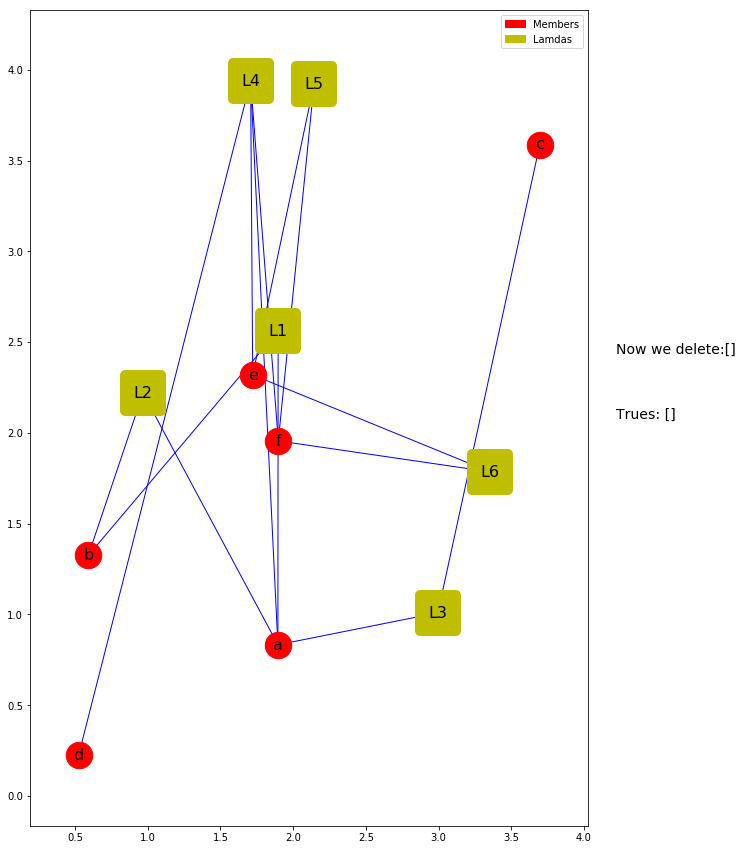

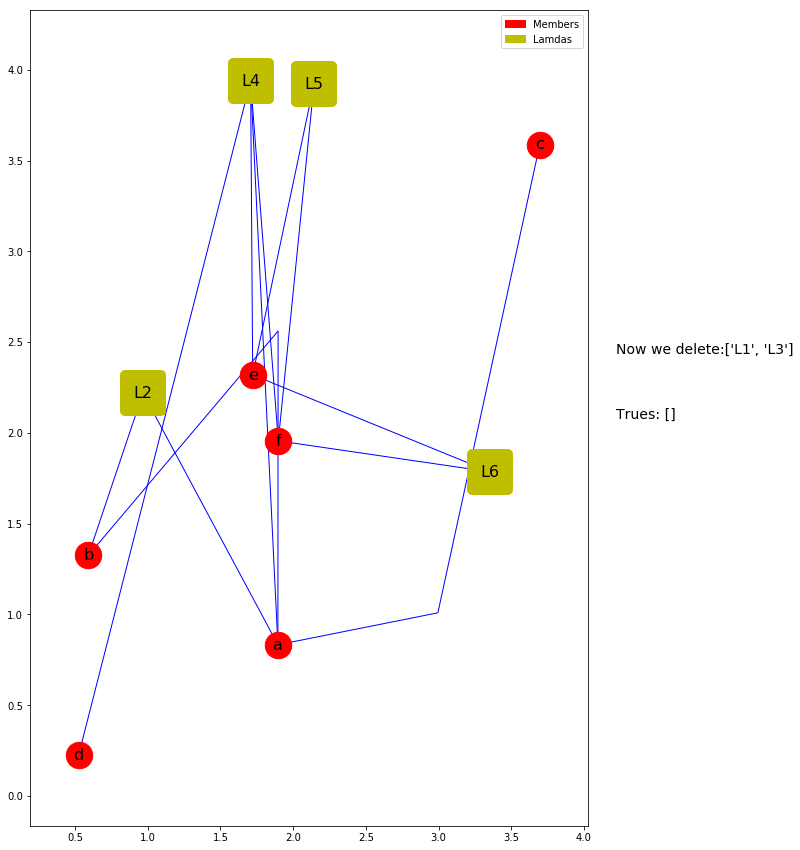

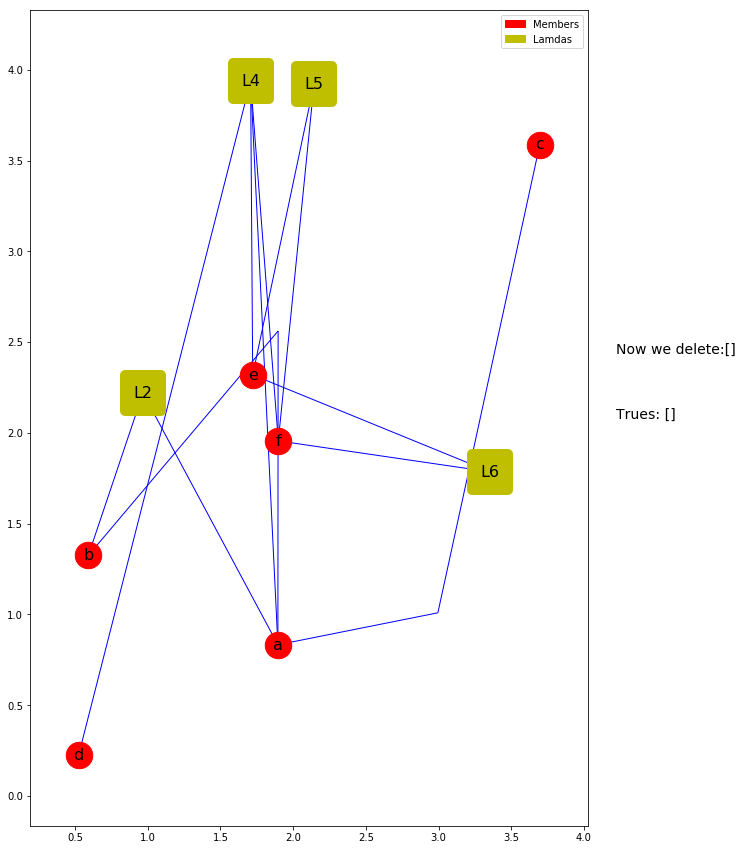

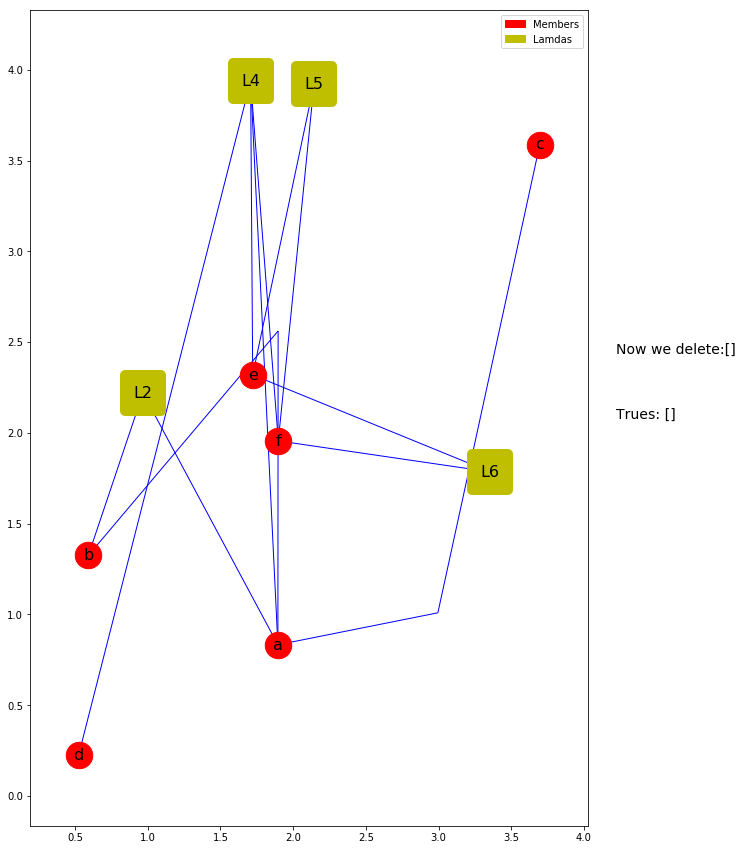

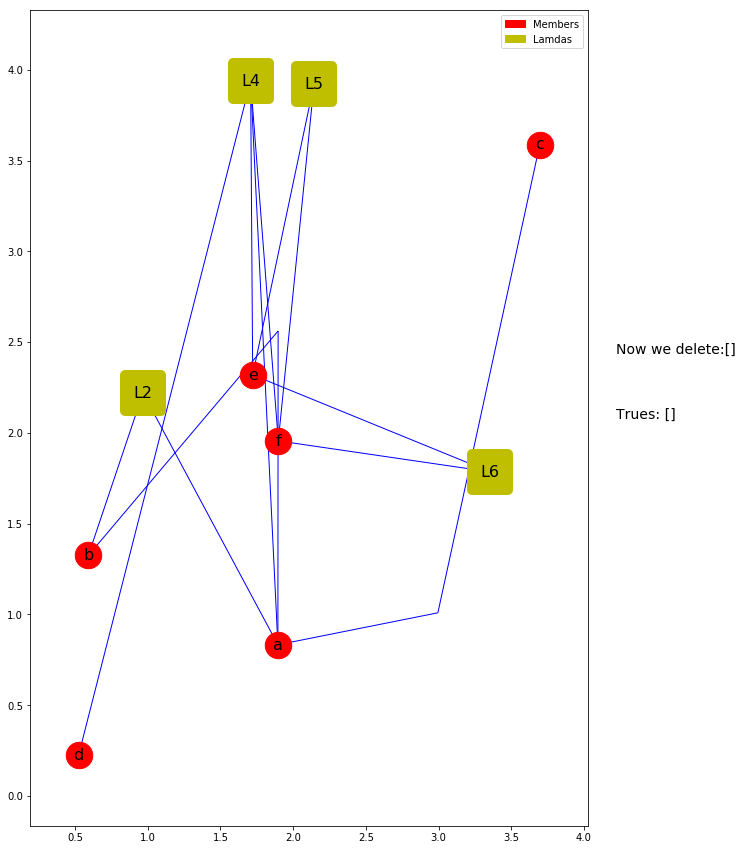

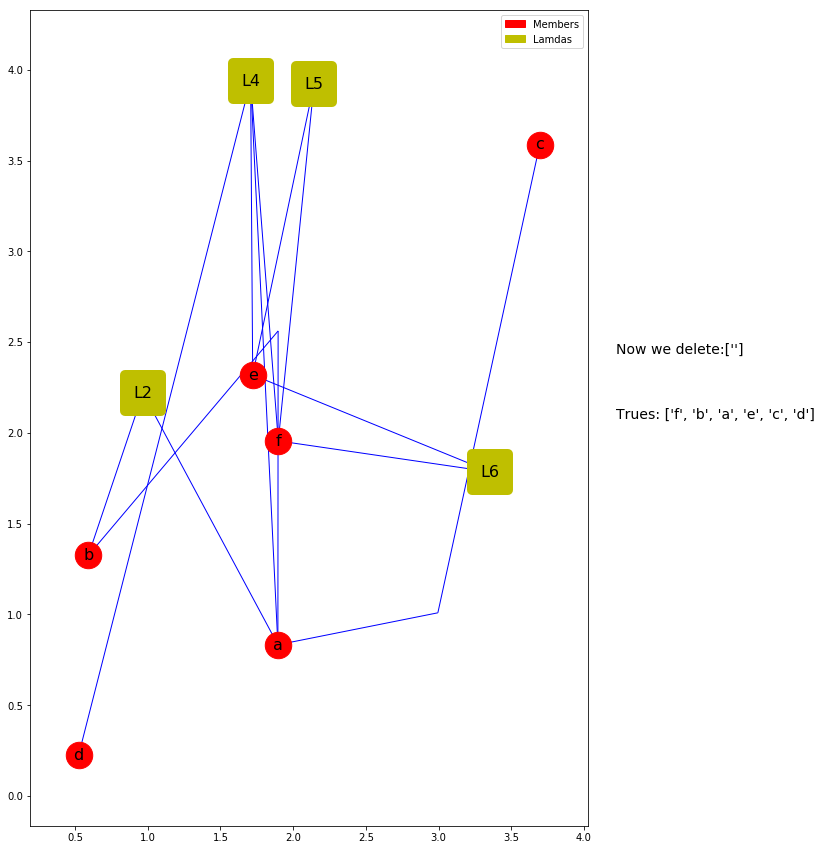

Results:
['f', 'b', 'a', 'e', 'c', 'd']
--------Finished--------


In [433]:
drawActive = True
# theory = readFile('example 1.txt')
main(theory)

In [398]:
drawActive = False
for i in range(10):
    print ('-------------------------')
    print ("Running N-", i)
    main(generateRandomSentences(10,2,15,1))



-------------------------
Running N- 0
L0:['l']->['g', 'd']
L1:['b', 'i']->[]
L2:['f']->[]
L3:['m']->[]
L4:['h']->[]
L5:['d']->['a']
L6:['j', 'b']->[]
L7:['k', 'k']->['c']
L8:['o']->['d', 'h']
L9:['n', 'g']->['f']
Results:
['h', 'c', 'd', 'a', 'g', 'f']
--------Finished--------
-------------------------
Running N- 1
L0:['a']->['l']
L1:['j']->['k']
L2:['g', 'h']->['g', 'i']
L3:['b', 'h']->['k']
L4:['c', 'e']->['j']
L5:['f']->['b', 'm']
L6:['i']->['e', 'k']
L7:['l']->[]
L8:['h', 'o']->['l']
L9:['h']->['l']
Results:
['m', 'i', 'l', 'j', 'k', 'b', 'g', 'e']
--------Finished--------
-------------------------
Running N- 2
L0:['o', 'j']->['k', 'o']
L1:['o', 'b']->[]
L2:['g', 'j']->['i']
L3:['k']->['d']
L4:['g', 'n']->[]
L5:['h', 'd']->['m', 'e']
L6:['h']->['k', 'h']
L7:['m', 'a']->['c']
L8:['o']->['f']
L9:['e', 'i']->['e', 'e']
Results:
['m', 'i', 'h', 'c', 'd', 'f', 'k', 'o', 'e']
--------Finished--------
-------------------------
Running N- 3
L0:['e']->['o', 'd']
L1:['m']->['e']
L2:['e']->[

In [249]:
originalSentences = 0